<h1><b>[II - Feature extraction 2]</b></h1>

This notebook extracts the more advanced features `neighb_nb`, `neighb_density` and `neighb_similar`.

It requires several hours to compute. Thus, the computed versions are also already available:

=> <b>it is not mandatory to run this notebook</b> (but it is provided for reproductibility).

Once computed, the features are saved in `neighb_density.npy`, `neighb_nb.npy` and `neighb_similar.npy`

In [1]:
import shapely
import geopandas as gpd
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)  

In [2]:
import time
start = time.time()

train_df_geojson = gpd.read_file('data/train.geojson', engine="pyogrio")
test_df_geojson = gpd.read_file('data/test.geojson', engine="pyogrio")

end = time.time()
print("Reading time:", end - start,"s")

Reading time: 153.39683198928833 s


In [3]:
train_df = train_df_geojson.copy()
test_df = test_df_geojson.copy()

In [4]:
train_long = np.array(train_df["geometry"].centroid.x)
train_lat = np.array(train_df["geometry"].centroid.y)
train_coords = np.stack((train_long, train_lat), axis=1)

test_long = np.array(test_df["geometry"].centroid.x)
test_lat = np.array(test_df["geometry"].centroid.y)
test_coords = np.stack((test_long, test_lat), axis=1)

In [5]:
all_coords = np.concatenate([train_coords, test_coords])
print(all_coords.shape)

(416672, 2)


In [6]:
from sklearn.neighbors import NearestNeighbors

model = NearestNeighbors(n_neighbors=20, algorithm='ball_tree').fit(all_coords)
distances, indices = model.kneighbors(all_coords)

In [7]:
from shapely.geometry import Polygon
from shapely.ops import unary_union

def center_polygon(poly):
    centroid = Polygon(poly).centroid
    translate = [-centroid.x, -centroid.y]
    centered_poly = [[point[0] + translate[0], point[1] + translate[1]] for point in poly.exterior.coords]
    return centered_poly


def calculate_similarity(poly1, poly2):
    # Create Shapely Polygon objects

    # Center the polygons
    centered_poly1 = center_polygon(poly1)
    centered_poly2 = center_polygon(poly2)

    # Create Shapely Polygon objects
    polygon1 = Polygon(centered_poly1)
    polygon2 = Polygon(centered_poly2)
    
    return polygon1.hausdorff_distance(polygon2)

0.08452248086734691 2 0.00017166320747579779


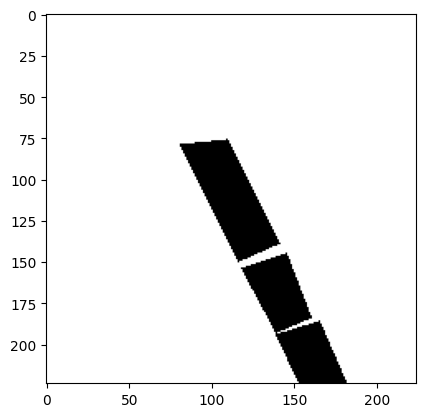

In [8]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

NB_TRAINS = len(train_df)
neighb_density = []
neighb_nb = []
neighb_similar = []
for iActuel in range(len(all_coords)):
    if iActuel < NB_TRAINS:
        col = train_df.iloc[iActuel]
    else:
        col = test_df.iloc[iActuel-NB_TRAINS]
    
    IMG_SIZE = 224
    IMG_CENTER = IMG_SIZE//2
    centroid = all_coords[iActuel]
    
    
    image = Image.new("RGB", (IMG_SIZE, IMG_SIZE), "white")
    draw = ImageDraw.Draw(image, 'RGBA')

    x,y = col["geometry"].exterior.xy
    x = np.array(x)
    y = np.array(y)
    (minx, miny, maxx, maxy) = col["geometry"].bounds

    echelle = 50000#60 / max((maxx-minx), (maxy-miny))
    nouvX = (x - centroid[0]) * echelle + IMG_CENTER
    nouvY = (y - centroid[1]) * echelle + IMG_CENTER
    nouvY = IMG_SIZE - nouvY
    
    #print(echelle)
    
    draw.polygon(list(zip(nouvX, nouvY)), fill="black")

    nbVoisinsDedans = 0
    visited = set()
    dists = []
    for iVoisin, distVoisin in zip(indices[iActuel], distances[iActuel]):
        
        xCentroidVoisin = (all_coords[iVoisin][0] - centroid[0]) * echelle + IMG_CENTER
        yCentroidVoisin = (all_coords[iVoisin][1] - centroid[1]) * echelle + IMG_CENTER
        
        if (xCentroidVoisin, yCentroidVoisin) in visited:
            continue
        visited.add((xCentroidVoisin, yCentroidVoisin))
        
                
        if xCentroidVoisin >= 0 and xCentroidVoisin < IMG_SIZE and yCentroidVoisin >= 0 and yCentroidVoisin < IMG_SIZE:
            nbVoisinsDedans += 1
            
        if distVoisin == 0:
            continue

        if iVoisin < NB_TRAINS:
            colVoisin = train_df.iloc[iVoisin]
        else:
            colVoisin = test_df.iloc[iVoisin-NB_TRAINS]
        
        x,y = colVoisin["geometry"].exterior.xy
        x = np.array(x)
        y = np.array(y)

        nouvX = (x - centroid[0]) * echelle + IMG_CENTER
        nouvY = (y - centroid[1]) * echelle + IMG_CENTER
        nouvY = IMG_SIZE - nouvY
        
        dists.append(calculate_similarity(col['geometry'], colVoisin['geometry']))
    
        if min(nouvX) > IMG_SIZE or max(nouvX) < 0 or min(nouvY) > IMG_SIZE or max(nouvY) < 0:
            continue
    
        draw.polygon(list(zip(nouvX, nouvY)), fill="black")
    
    dists = sorted(dists)
    #print(dists)
    mean_dist = np.mean(dists[:5])
    
    density = (255 - np.mean(image))/255
    
    #plt.imshow(image)
    #print(density, nbVoisinsDedans, mean_dist)
    #plt.show()
    #break
    
    neighb_density.append(density)
    neighb_nb.append(nbVoisinsDedans)
    neighb_similar.append(mean_dist)


In [ ]:
np.save("data/neighb_density", neighb_density)
np.save("data/neighb_nb", neighb_nb)
np.save("data/neighb_similar", neighb_similar)